In [1]:
# для работы с программным кодом R в Jupiter,
# запустите Anaconda Prompt и установите 
# пакет r-essentials с помощью строки 
# conda install r-essentials

# подключаем пакеты
library(caret)
library(dplyr)
library(imputeMissings)
library(Hmisc)
library(CHAID)
library(randomForest)
library(ranger)
library(memisc)
library(ggplot2)
library(doParallel)
library(pROC)
library(rcompanion)
library(car)

Loading required package: lattice
Loading required package: ggplot2

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'imputeMissings'

The following object is masked from 'package:dplyr':

    compute

Loading required package: survival

Attaching package: 'survival'

The following object is masked from 'package:caret':

    cluster

Loading required package: Formula

Attaching package: 'Hmisc'

The following object is masked from 'package:imputeMissings':

    impute

The following objects are masked from 'package:dplyr':

    combine, src, summarize

The following objects are masked from 'package:base':

    format.pval, round.POSIXt, trunc.POSIXt, units

Loading required package: partykit
Loading required package: grid
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'rando

In [2]:
# создаем рабочее пространство с файлами выборки
setwd("C:/Trees")

In [3]:
# загружаем данные
OTPset <- read.csv2("Credit_OTP.csv", stringsAsFactors = F)
OTPset_test <- read.csv2("Credit_OTP_new.csv", stringsAsFactors = F)

In [4]:
# смотрим количество уникальных значений у AGREEMENT_RK 
length(unique(OTPset$AGREEMENT_RK))

[1] 15223

In [5]:
# удаляем переменную AGREEMENT_RK
OTPset$AGREEMENT_RK <- NULL

In [6]:
# смотрим типы переменных
str(OTPset)

'data.frame':	15223 obs. of  51 variables:
 $ TARGET                    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ AGE                       : int  49 32 52 39 30 29 35 41 53 43 ...
 $ SOCSTATUS_WORK_FL         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ SOCSTATUS_PENS_FL         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ GENDER                    : int  1 1 1 1 0 0 0 1 0 1 ...
 $ CHILD_TOTAL               : int  2 3 4 1 0 0 1 0 2 0 ...
 $ DEPENDANTS                : int  1 3 0 1 0 0 1 0 0 0 ...
 $ EDUCATION                 : chr  "Среднее специальное" "Среднее" "Неполное среднее" "Высшее" ...
 $ MARITAL_STATUS            : chr  "Состою в браке" "Состою в браке" "Состою в браке" "Состою в браке" ...
 $ GEN_INDUSTRY              : chr  "Торговля" "Торговля" "Информационные технологии" "Образование" ...
 $ GEN_TITLE                 : chr  "Рабочий" "Рабочий" "Специалист" "Руководитель среднего звена" ...
 $ ORG_TP_STATE              : chr  "Частная компания" "Индивидуальный предприниматель" "Государственная комп./у

In [7]:
# пишем функцию для проставления метки "Не указано"
nonInformation <- 
  function(variable) {
    variable <- ifelse(variable == "" | variable == "Пропуск", "Не указано", 
                       variable)
    return(variable)
  }

In [8]:
# пишем функцию предобработки для приведения переменных к нужному формату, 
# удаления переменной с одним уникальным значением,
# создания переменной на соответствие адресов
preProcessData <- 
  function(data) {
    data <- 
      data %>%
      dplyr::mutate(
        TARGET = factor(TARGET, levels = c(0,1), labels = c("noResponse", "Response")),
        SOCSTATUS_WORK_FL = as.factor(SOCSTATUS_WORK_FL),
        SOCSTATUS_PENS_FL = as.factor(SOCSTATUS_PENS_FL),
        GENDER = as.factor(GENDER),
        MARITAL_STATUS = as.factor(MARITAL_STATUS),
        FAMILY_INCOME = as.numeric(as.factor(FAMILY_INCOME)),
        GEN_INDUSTRY = ifelse(GEN_INDUSTRY == "" & SOCSTATUS_PENS_FL == 1,
                              "Пенсия", GEN_INDUSTRY),
        GEN_INDUSTRY = nonInformation(GEN_INDUSTRY),
        GEN_TITLE = ifelse(GEN_TITLE == "" & SOCSTATUS_PENS_FL == 1,
                           "Пенсия", GEN_TITLE),
        GEN_TITLE = nonInformation(GEN_TITLE),
        ORG_TP_STATE = ifelse(ORG_TP_STATE == "" & SOCSTATUS_PENS_FL == 1,
                              "Пенсия", ORG_TP_STATE),
        ORG_TP_STATE = nonInformation(ORG_TP_STATE),
        ORG_TP_FCAPITAL = ifelse(ORG_TP_FCAPITAL == "" & SOCSTATUS_PENS_FL == 1,
                                 "Пенсия", ORG_TP_FCAPITAL),
        ORG_TP_FCAPITAL = nonInformation(ORG_TP_FCAPITAL),
        JOB_DIR = ifelse(JOB_DIR == "" & SOCSTATUS_PENS_FL == 1,
                         "Пенсия", JOB_DIR),
        JOB_DIR = nonInformation(JOB_DIR),
        TP_PROVINCE = nonInformation(TP_PROVINCE),
        REGION_NM = nonInformation(REGION_NM),
        REGION_NM = ifelse(REGION_NM == "ПОВОЛЖСКИЙ", "ПРИВОЛЖСКИЙ", REGION_NM),  
        REG_FACT_FL = as.factor(REG_FACT_FL),
        FACT_POST_FL = as.factor(FACT_POST_FL),
        REG_POST_FL = as.factor(REG_POST_FL),
        REG_FACT_POST_FL = as.factor(REG_FACT_POST_FL),
        FL_PRESENCE_FL = as.factor(FL_PRESENCE_FL),
        AUTO_RUS_FL = as.factor(AUTO_RUS_FL),
        HS_PRESENCE_FL = as.factor(HS_PRESENCE_FL),
        COT_PRESENCE_FL = as.factor(COT_PRESENCE_FL),
        GAR_PRESENCE_FL = as.factor(GAR_PRESENCE_FL),
        LAND_PRESENCE_FL = as.factor(LAND_PRESENCE_FL),
        DL_DOCUMENT_FL = NULL,
        GPF_DOCUMENT_FL = as.factor(GPF_DOCUMENT_FL),
        FACT_PHONE_FL = as.factor(FACT_PHONE_FL),
        REG_PHONE_FL = as.factor(REG_PHONE_FL),
        GEN_PHONE_FL = as.factor(GEN_PHONE_FL),
        PREVIOUS_CARD_NUM_UTILIZED =
          ifelse(is.na(PREVIOUS_CARD_NUM_UTILIZED), 0, PREVIOUS_CARD_NUM_UTILIZED),
        # факт совпадения фактического области проживания и торговой точки
        FACT_TP_FL = as.factor(ifelse(FACT_ADDRESS_PROVINCE == TP_PROVINCE, 1, 0))
      )
    return(data)
  }

In [9]:
# пишем функцию предобработки для тестового набора
preProcessDataTest <- 
  function(data) {
    data <- 
      data %>%
      dplyr::mutate(
        TARGET = factor(TARGET, levels = c(0,1), labels = c("noResponse", "Response")),
        SOCSTATUS_WORK_FL = as.factor(SOCSTATUS_WORK_FL),
        SOCSTATUS_PENS_FL = as.factor(SOCSTATUS_PENS_FL),
        GENDER = as.factor(GENDER),
        MARITAL_STATUS = as.factor(MARITAL_STATUS),
        FAMILY_INCOME = as.numeric(as.factor(FAMILY_INCOME)),
        GEN_INDUSTRY = ifelse(GEN_INDUSTRY == "Пропуск" & SOCSTATUS_PENS_FL == 1,
                              "Пенсия", GEN_INDUSTRY),
        GEN_INDUSTRY = nonInformation(GEN_INDUSTRY),
        GEN_TITLE = ifelse(GEN_TITLE == "Пропуск" & SOCSTATUS_PENS_FL == 1,
                           "Пенсия", GEN_TITLE),
        GEN_TITLE = nonInformation(GEN_TITLE),
        ORG_TP_STATE = ifelse(ORG_TP_STATE == "Пропуск" & SOCSTATUS_PENS_FL == 1,
                              "Пенсия", ORG_TP_STATE),
        ORG_TP_STATE = nonInformation(ORG_TP_STATE),
        ORG_TP_FCAPITAL = ifelse(ORG_TP_FCAPITAL == "Пропуск" & SOCSTATUS_PENS_FL == 1,
                                 "Пенсия", ORG_TP_FCAPITAL),
        ORG_TP_FCAPITAL = nonInformation(ORG_TP_FCAPITAL),
        JOB_DIR = ifelse(JOB_DIR == "Пропуск" & SOCSTATUS_PENS_FL == 1,
                         "Пенсия", JOB_DIR),
        JOB_DIR = nonInformation(JOB_DIR),
        TP_PROVINCE = nonInformation(TP_PROVINCE),
        REGION_NM = nonInformation(REGION_NM),
        REG_FACT_FL = as.factor(REG_FACT_FL),
        FACT_POST_FL = as.factor(FACT_POST_FL),
        REG_POST_FL = as.factor(REG_POST_FL),
        REG_FACT_POST_FL = as.factor(REG_FACT_POST_FL),
        FL_PRESENCE_FL = as.factor(FL_PRESENCE_FL),
        AUTO_RUS_FL = as.factor(AUTO_RUS_FL),
        HS_PRESENCE_FL = as.factor(HS_PRESENCE_FL),
        COT_PRESENCE_FL = as.factor(COT_PRESENCE_FL),
        GAR_PRESENCE_FL = as.factor(GAR_PRESENCE_FL),
        LAND_PRESENCE_FL = as.factor(LAND_PRESENCE_FL),
        DL_DOCUMENT_FL = NULL,
        GPF_DOCUMENT_FL = as.factor(GPF_DOCUMENT_FL),
        FACT_PHONE_FL = as.factor(FACT_PHONE_FL),
        REG_PHONE_FL = as.factor(REG_PHONE_FL),
        GEN_PHONE_FL = as.factor(GEN_PHONE_FL),
        PREVIOUS_CARD_NUM_UTILIZED =
          ifelse(is.na(PREVIOUS_CARD_NUM_UTILIZED), 0, PREVIOUS_CARD_NUM_UTILIZED),
        # факт совпадения фактического области проживания и торговой точки
        FACT_TP_FL = as.factor(ifelse(FACT_ADDRESS_PROVINCE == TP_PROVINCE, 1, 0))
      )
    return(data)
  }

In [10]:
# применяем функции предобработки
# к набору данных
OTPset <- preProcessData(OTPset)

In [11]:
# выводим подробную информацию
# о переменных
Hmisc::describe(OTPset)

OTPset 

 51  Variables      15223  Observations
--------------------------------------------------------------------------------
TARGET 
       n  missing distinct 
   15223        0        2 
                                
Value      noResponse   Response
Frequency       13411       1812
Proportion      0.881      0.119
--------------------------------------------------------------------------------
AGE 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
   15223        0       47    0.999    40.41    13.34       24       25 
     .25      .50      .75      .90      .95 
      30       39       50       57       60 

lowest : 21 22 23 24 25, highest: 63 64 65 66 67
--------------------------------------------------------------------------------
SOCSTATUS_WORK_FL 
       n  missing distinct 
   15223        0        2 
                      
Value          0     1
Frequency   1376 13847
Proportion  0.09  0.91
----------------------------------------------------

In [12]:
# разбиваем на обучающую и тестовую выборки
set.seed(45151)
index = createDataPartition(OTPset$TARGET, p = 0.7, list = F)
training <- OTPset[index,]
testing <- OTPset[-index,]

In [13]:
# пишем функцию для анализа редких категорий
freqTable <- 
  function(variable) {
    FreqTable <- data.frame(table(variable))
    FreqTable <- 
      FreqTable %>% 
      mutate(Share = Freq/sum(Freq)) %>%
      arrange(desc(Share)) %>%
      mutate(Cumshare = cumsum(Share))
    return(FreqTable)
  }

In [14]:
# выводим обычные и накопленные доли 
# категорий переменной GEN_INDUSTRY, с помощью 
# options(scipen=999) отключаем 
# экспоненциальное представление чисел
options(scipen=999)
FreqGEN_INDUSTRY <- freqTable(training$GEN_INDUSTRY)
FreqGEN_INDUSTRY

variable,Freq,Share,Cumshare
Торговля,1644,0.15426480248,0.1542648
Другие сферы,1193,0.11194520034,0.2662100
Пенсия,954,0.08951862626,0.3557286
Металлургия/Промышленность/Машиностроение,922,0.08651590504,0.4422445
Государственная служба,917,0.08604672985,0.5282913
Здравоохранение,839,0.07872759688,0.6070189
Образование,719,0.06746739232,0.6744863
Транспорт,531,0.04982640518,0.7243127
Сельское хозяйство,491,0.04607300366,0.7703857
Строительство,414,0.03884770573,0.8092334


In [15]:
# выводим частоты категорий переменной GEN_TITLE
table(training$GEN_TITLE)


   Военнослужащий по контракту     Высококвалифиц. специалист 
                            65                            397 
                        Другое Индивидуальный предприниматель 
                           126                            158 
                    Не указано                        Партнер 
                             1                              8 
                        Пенсия           Работник сферы услуг 
                           954                            404 
                       Рабочий     Руководитель высшего звена 
                          2166                            308 
    Руководитель низшего звена    Руководитель среднего звена 
                           103                            479 
                      Служащий                     Специалист 
                           629                           4859 

In [16]:
# выводим обычные и накопленные доли 
# категорий переменной GEN_TITLE
FreqGEN_TITLE <- freqTable(training$GEN_TITLE)
FreqGEN_TITLE

variable,Freq,Share,Cumshare
Специалист,4859,0.45594444966,0.4559444
Рабочий,2166,0.20324669231,0.6591911
Пенсия,954,0.08951862626,0.7487098
Служащий,629,0.05902223890,0.8077320
Руководитель среднего звена,479,0.04494698320,0.8526790
Работник сферы услуг,404,0.03790935535,0.8905883
Высококвалифиц. специалист,397,0.03725251009,0.9278409
Руководитель высшего звена,308,0.02890119170,0.9567420
Индивидуальный предприниматель,158,0.01482593600,0.9715680
Другое,126,0.01182321479,0.9833912


In [17]:
# смотрим средний личный доход в каждой
# категории переменной GEN_TITLE
training %>% group_by(GEN_TITLE) %>%
  summarise(PERSONAL_INCOME = mean(PERSONAL_INCOME))

GEN_TITLE,PERSONAL_INCOME
Военнослужащий по контракту,20938.462
Высококвалифиц. специалист,19066.247
Другое,12823.810
Индивидуальный предприниматель,19232.278
Не указано,10000.000
Партнер,20075.000
Пенсия,8317.948
Работник сферы услуг,12395.446
Рабочий,12320.485
Руководитель высшего звена,24026.948


In [18]:
# выводим частоты категорий переменной ORG_TP_STATE
table(training$ORG_TP_STATE)


  Государственная комп./учреж. Индивидуальный предприниматель 
                          4322                            665 
                    Не указано     Некоммерческая организация 
                             1                            167 
                        Пенсия Частная ком. с инос. капиталом 
                           954                             14 
              Частная компания 
                          4534 

In [19]:
# выводим частоты категорий переменной REG_ADDRESS_PROVINCE
table(training$REG_ADDRESS_PROVINCE)


      Агинский Бурятский АО                      Адыгея 
                          2                          93 
             Алтайский край            Амурская область 
                        329                         126 
      Архангельская область        Астраханская область 
                        182                          91 
                   Башкирия        Белгородская область 
                        156                         139 
           Брянская область                     Бурятия 
                        119                         132 
       Владимирская область       Волгоградская область 
                        120                         235 
        Вологодская область         Воронежская область 
                        207                         205 
               Горный Алтай                    Дагестан 
                         48                           2 
               Еврейская АО          Ивановская область 
                         46   

In [20]:
# выводим обычные и накопленные доли 
# категорий переменной REG_ADDRESS_PROVINCE
FreqREG_ADDRESS_PROVINCE <- freqTable(training$REG_ADDRESS_PROVINCE)
FreqREG_ADDRESS_PROVINCE

variable,Freq,Share,Cumshare
Кемеровская область,477,0.04475931,0.04475931
Краснодарский край,455,0.04269494,0.08745426
Алтайский край,329,0.03087173,0.11832598
Приморский край,305,0.02861969,0.14694567
Читинская область,304,0.02852585,0.17547152
Ростовская область,283,0.02655532,0.20202684
Свердловская область,253,0.02374026,0.22576710
Волгоградская область,235,0.02205123,0.24781834
Саратовская область,215,0.02017453,0.26799287
Татарстан,214,0.02008070,0.28807357


In [21]:
# выводим частоты категорий переменной FACT_ADDRESS_PROVINCE
table(training$FACT_ADDRESS_PROVINCE)


      Агинский Бурятский АО                      Адыгея 
                          2                          94 
             Алтайский край            Амурская область 
                        327                         125 
      Архангельская область        Астраханская область 
                        181                          89 
                   Башкирия        Белгородская область 
                        156                         137 
           Брянская область                     Бурятия 
                        118                         131 
       Владимирская область       Волгоградская область 
                        118                         236 
        Вологодская область         Воронежская область 
                        207                         206 
               Горный Алтай                Еврейская АО 
                         48                          48 
         Ивановская область           Иркутская область 
                        117   

In [22]:
# выводим частоты категорий переменной POSTAL_ADDRESS_PROVINCE
table(training$POSTAL_ADDRESS_PROVINCE)


      Агинский Бурятский АО                      Адыгея 
                          2                          93 
             Алтайский край            Амурская область 
                        328                         125 
      Архангельская область        Астраханская область 
                        181                          90 
                   Башкирия        Белгородская область 
                        156                         136 
           Брянская область                     Бурятия 
                        118                         131 
       Владимирская область       Волгоградская область 
                        118                         235 
        Вологодская область         Воронежская область 
                        208                         206 
               Горный Алтай                Еврейская АО 
                         48                          48 
         Ивановская область           Иркутская область 
                        117   

In [23]:
# выводим частоты категорий переменной TP_PROVINCE
table(training$TP_PROVINCE)


                 Адыгея          Алтайский край        Амурская область 
                     67                     316                     152 
  Архангельская область    Астраханская область                Башкирия 
                    172                      89                     110 
   Белгородская область        Брянская область                 Бурятия 
                    136                     121                     145 
   Владимирская область   Волгоградская область     Вологодская область 
                    118                     240                     207 
    Воронежская область            Горный Алтай            Еврейская АО 
                    213                      52                      47 
     Ивановская область       Иркутская область      Кабардино-Балкария 
                    117                     138                       8 
Калининградская область       Калужская область      Камчатская область 
                    104                      87   

In [24]:
# выводим обычные и накопленные доли 
# категорий переменной TP_PROVINCE
FreqTP_PROVINCE <- freqTable(training$TP_PROVINCE)
FreqTP_PROVINCE

variable,Freq,Share,Cumshare
Краснодарский край,540,0.05067092,0.05067092
Кемеровская область,473,0.04438397,0.09505489
Алтайский край,316,0.02965187,0.12470677
Приморский край,302,0.02833818,0.15304495
Ставропольский край,297,0.02786901,0.18091395
Читинская область,292,0.02739983,0.20831378
Ростовская область,283,0.02655532,0.23486910
Челябинская область,255,0.02392793,0.25879703
Свердловская область,248,0.02327109,0.28206812
Волгоградская область,240,0.02252041,0.30458853


In [25]:
# выводим частоты категорий переменной JOB_DIR
table(training$JOB_DIR)


    Адм-хоз. и трансп. службы Бухгалтерия, финансы, планир. 
                          189                           353 
  Вспомогательный техперсонал Кадровая служба и секретариат 
                          728                            70 
                   Не указано                        Пенсия 
                            1                           954 
   Пр-техн. обесп. и телеком.           Реклама и маркетинг 
                           48                             5 
          Служба безопасности              Снабжение и сбыт 
                          121                           158 
Участие в основ. деятельности            Юридическая служба 
                         7993                            37 

In [26]:
# выводим обычные и накопленные доли 
# категорий переменной JOB_DIR
FreqJOB_DIR <- freqTable(training$JOB_DIR) 

In [27]:
# выводим частоты категорий переменной REGION_NM
table(training$REGION_NM)


ВОСТОЧНО-СИБИРСКИЙ    ДАЛЬНЕВОСТОЧНЫЙ  ЗАПАДНО-СИБИРСКИЙ         Не указано 
               899                813               1288                  1 
       ПРИВОЛЖСКИЙ    СЕВЕРО-ЗАПАДНЫЙ          УРАЛЬСКИЙ      ЦЕНТРАЛЬНЫЙ 1 
              1885                712                846               1135 
     ЦЕНТРАЛЬНЫЙ 2   ЦЕНТРАЛЬНЫЙ ОФИС              ЮЖНЫЙ 
              1339                215               1524 

In [28]:
# пишем функцию по укрупнению "редких" регионов
replaceRareRegion <- 
  function(region) {
    region = ifelse(region == "Москва" | region == "Хакасия" |
                      region == "Ямало-Ненецкий АО" | region == "Магаданская область" |
                      region == "Калмыкия" | region == "Дагестан" |
                      region == "Агинский Бурятский АО" | 
                      region == "Усть-Ордынский Бурятский АО" |
                      region == "Эвенкийский АО" | region == "Коми-Пермяцкий АО" |
                      region == "Коми-Пермяцкий АО" | region == "Чечня", 
                    "Другие регионы",
                    region)
    region = as.factor(region)
    return(region)
  }

In [29]:
# пишем функцию по укрупнению редких категорий
replaceRareClass <- 
  function(data) {
    data <- 
      data %>%
      dplyr::mutate(
        EDUCATION = 
          as.factor(
            ifelse(EDUCATION == "Ученая степень" | 
                     EDUCATION == "Два и более высших образования" |
                     EDUCATION == "Высшее",
                   "Высшее или несколько высших", EDUCATION)
          ),
        GEN_INDUSTRY = 
          as.factor(
            ifelse(GEN_INDUSTRY == "Юридические услуги/нотариальные услуги" | 
                     GEN_INDUSTRY == "Страхование" |
                     GEN_INDUSTRY == "Туризм" |
                     GEN_INDUSTRY == "Недвижимость" |
                     GEN_INDUSTRY == "Управляющая компания" |
                     GEN_INDUSTRY == "Логистика" |
                     GEN_INDUSTRY == "Подбор персонала" |
                     GEN_INDUSTRY == "Маркетинг" |
                     GEN_INDUSTRY == "Не указано", "Другие сферы", GEN_INDUSTRY)
          ),
        GEN_TITLE = as.factor(
          ifelse(GEN_TITLE == "Партнер" | GEN_TITLE == "Не указано" |
                   GEN_TITLE == "Военнослужащий по контракту", 
                 "Другое", GEN_TITLE)
        ),
        ORG_TP_STATE = as.factor(
          ifelse(ORG_TP_STATE == "Частная ком. с инос. капиталом" |
                   ORG_TP_STATE == "Не указано",
                 "Частная компания", ORG_TP_STATE)
        ),
        ORG_TP_FCAPITAL = as.factor(
          ifelse(ORG_TP_FCAPITAL == "Не указано", "Без участия", ORG_TP_FCAPITAL)
        ),
        JOB_DIR = 
          as.factor(ifelse(JOB_DIR == "Кадровая служба и секретариат" |
                             JOB_DIR == "Пр-техн. обесп. и телеком." |
                             JOB_DIR == "Юридическая служба" |
                             JOB_DIR == "Реклама и маркетинг" |
                             JOB_DIR == "Не указано",
                           "Другие направления", JOB_DIR)),
        REGION_NM =
          as.factor(ifelse(REGION_NM == "Не указано", "ЮЖНЫЙ", REGION_NM)),
        REG_ADDRESS_PROVINCE = replaceRareRegion(REG_ADDRESS_PROVINCE),
        FACT_ADDRESS_PROVINCE = replaceRareRegion(FACT_ADDRESS_PROVINCE),
        POSTAL_ADDRESS_PROVINCE = replaceRareRegion(POSTAL_ADDRESS_PROVINCE),
        TP_PROVINCE = as.factor(
          ifelse(TP_PROVINCE == "Сахалинская область" | TP_PROVINCE == "Еврейская АО" |
                   TP_PROVINCE == "Магаданская область" | 
                   TP_PROVINCE == "Москва" |
                   TP_PROVINCE == "Кабардино-Балкария" |
                   TP_PROVINCE == "1", "Другие регионы", TP_PROVINCE)
        )
      )
    return(data)
  }


In [30]:
# применяем функцию, укрупняющую редкие
# категории, к обучающей выборке
training <- replaceRareClass(training)

In [31]:
# пишем функцию, обрабатывающую выбросы
replaceOutlier <- 
  function(data) {
    data <- 
      data %>% mutate(
        FACT_LIVING_TERM = 
          ifelse(FACT_LIVING_TERM < 0, abs(FACT_LIVING_TERM), FACT_LIVING_TERM),
        FACT_LIVING_TERM = 
          ifelse(FACT_LIVING_TERM > quantile(FACT_LIVING_TERM, 0.999), NA, 
                 FACT_LIVING_TERM),
        WORK_TIME = 
          ifelse(WORK_TIME > quantile(WORK_TIME, 0.999, na.rm = T), NA, WORK_TIME)
      )
    return(data)
  }

In [32]:
# применяем функцию, обрабатывающую выбросы,
# к обучающей выборке
training <- replaceOutlier(training)

In [33]:
# смотрим количество пропусков по каждой переменной
# в обучающей выборке
sapply(training, function(x) sum(is.na(x)))

TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_ADDRESS_PROVINCE                TP_PROVINCE 
                         0                          0 
                 REGION_NM                REG_FACT_FL 
                         0                          0 
              FACT_POST_FL                REG_POST_FL 
                         0                          0 
          REG_FACT_POST_FL        REG_FACT_POST_TP_FL 
                         0                          0 
            FL_PRESENCE_FL                   OWN_AUTO 
                         0                          0 
               AUTO_RUS_FL             HS_PRESENCE_FL 
                         0                          0 
           COT_PRESENCE_FL            GAR_PRESENCE_FL 
                         0                          0 
          LAND_PRESENCE_FL                     CREDIT 
                         0                          0 
                      TERM                FST_PAYMENT 
                         0                          0 
           GPF_DOCUMENT_FL           FACT_LIVING_TERM 
                         0                         10 
                 WORK_TIME              FACT_PHONE_FL 
                       966                          0 
              REG_PHONE_FL               GEN_PHONE_FL 
                         0                          0 
            LOAN_NUM_TOTAL            LOAN_NUM_CLOSED 
                         0                          0 
             LOAN_NUM_PAYM               LOAN_DLQ_NUM 
                         0                          0 
              LOAN_MAX_DLQ           LOAN_AVG_DLQ_AMT 
                         0                          0 
          LOAN_MAX_DLQ_AMT PREVIOUS_CARD_NUM_UTILIZED 
                         0                          0 
                FACT_TP_FL 
                         0

In [34]:
# импутируем пропуски в количественных 
# переменных медианами
training[sapply(training, is.numeric)] <- lapply(training[sapply(training, is.numeric)], 
                                                 function(x) 
                                                     ifelse(is.na(x),
                                                            median(x, na.rm = TRUE), x))

In [35]:
# смотрим количество пропусков по каждой переменной
# в обучающей выборке
sapply(training, function(x) sum(is.na(x)))

TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_ADDRESS_PROVINCE                TP_PROVINCE 
                         0                          0 
                 REGION_NM                REG_FACT_FL 
                         0                          0 
              FACT_POST_FL                REG_POST_FL 
                         0                          0 
          REG_FACT_POST_FL        REG_FACT_POST_TP_FL 
                         0                          0 
            FL_PRESENCE_FL                   OWN_AUTO 
                         0                          0 
               AUTO_RUS_FL             HS_PRESENCE_FL 
                         0                          0 
           COT_PRESENCE_FL            GAR_PRESENCE_FL 
                         0                          0 
          LAND_PRESENCE_FL                     CREDIT 
                         0                          0 
                      TERM                FST_PAYMENT 
                         0                          0 
           GPF_DOCUMENT_FL           FACT_LIVING_TERM 
                         0                          0 
                 WORK_TIME              FACT_PHONE_FL 
                         0                          0 
              REG_PHONE_FL               GEN_PHONE_FL 
                         0                          0 
            LOAN_NUM_TOTAL            LOAN_NUM_CLOSED 
                         0                          0 
             LOAN_NUM_PAYM               LOAN_DLQ_NUM 
                         0                          0 
              LOAN_MAX_DLQ           LOAN_AVG_DLQ_AMT 
                         0                          0 
          LOAN_MAX_DLQ_AMT PREVIOUS_CARD_NUM_UTILIZED 
                         0                          0 
                FACT_TP_FL 
                         0

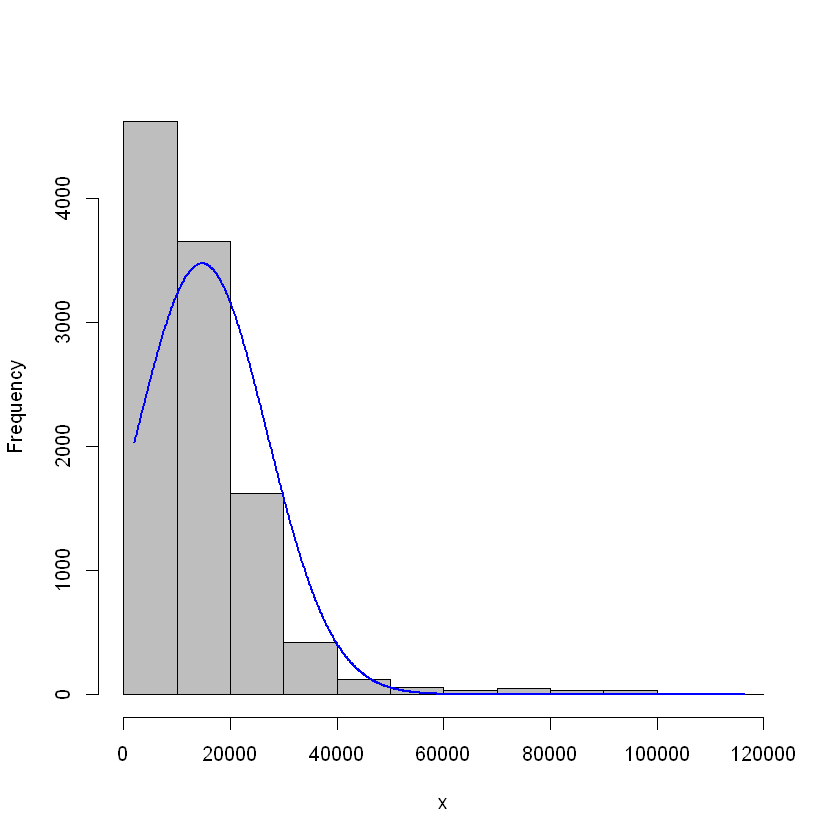

In [36]:
# выводим гистограмму распределения для переменной CREDIT 
# с помощью функции plotNormalHistogram пакета rcompanion
plotNormalHistogram(training$CREDIT)

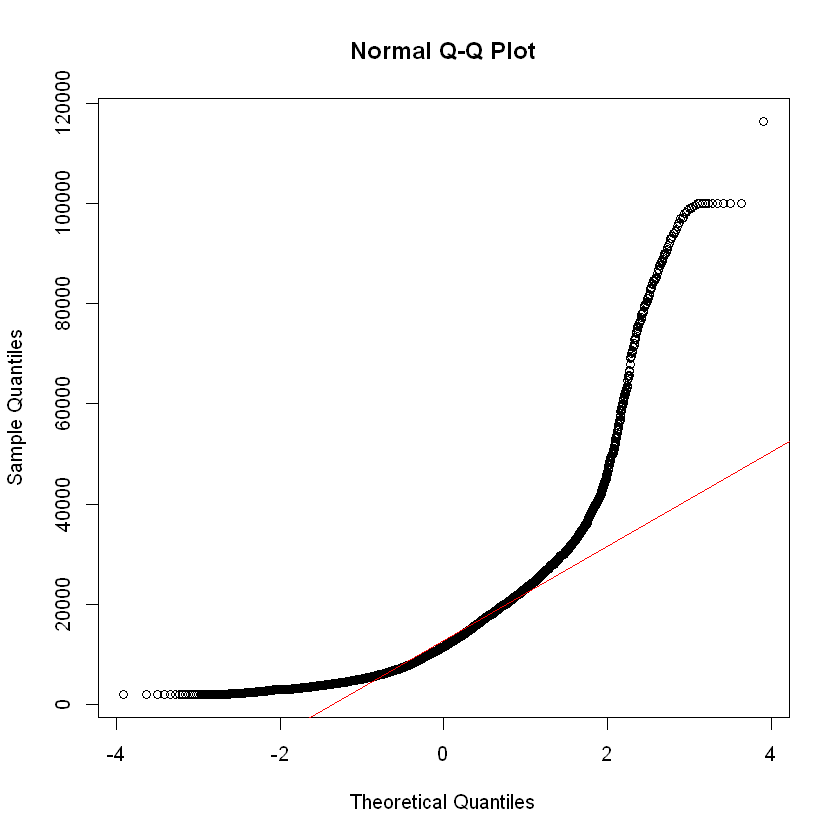

In [37]:
# выводим график квантиль-квантиль для переменной CREDIT
# с помощью функций qqnorm и qqline
qqnorm(training$CREDIT,
       ylab="Sample Quantiles")
qqline(training$CREDIT, 
       col="red")

In [38]:
# выполняем логарифмическое преобразование переменной
# CREDIT, используем константу 0.01, чтобы не брать
# логарифм нуля
var_log = log(training$CREDIT+0.01)

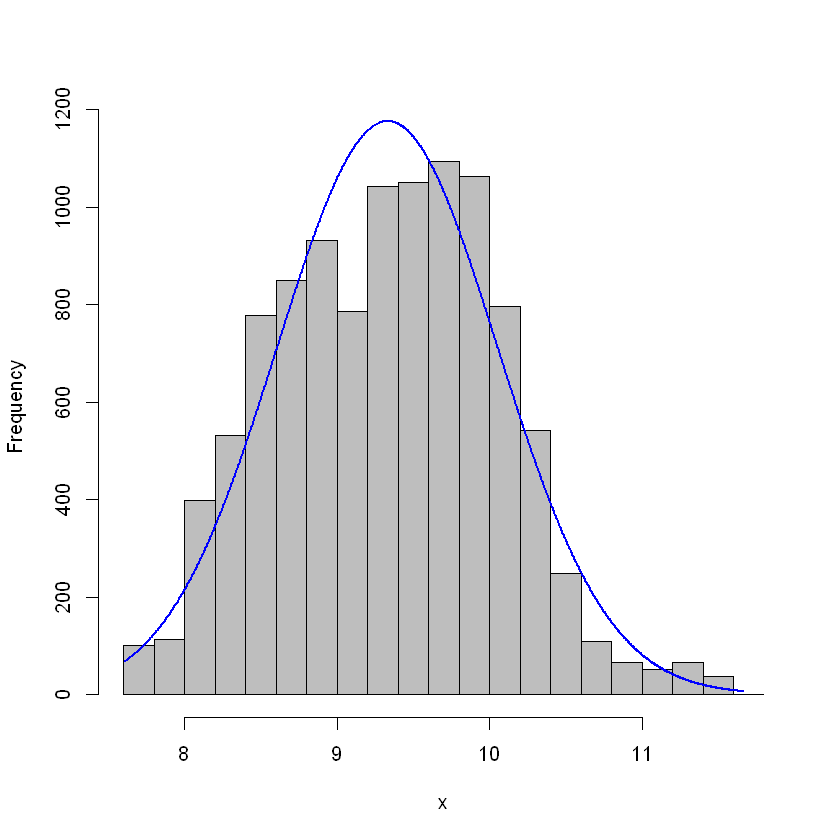

In [39]:
# выводим гистограмму распределения
# для преобразованной переменной CREDIT
plotNormalHistogram(var_log)

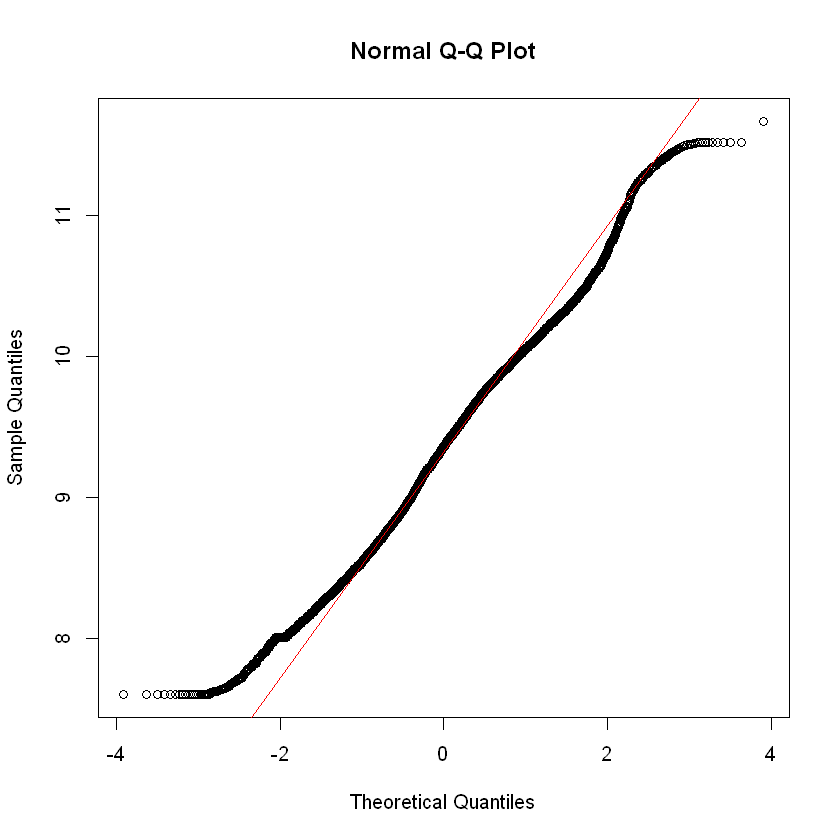

In [40]:
# выводим график квантиль-квантиль
# для преобразованной переменной CREDIT
qqnorm(var_log,
       ylab="Sample Quantiles")
qqline(var_log, 
       col="red")

In [41]:
# выполняем преобразование корней третьей степени,
# используем модуль, чтобы не вычислять корни
# отрицательных чисел, и затем учитываем знак числа
var_cube = sign(training$CREDIT) * abs(training$CREDIT)^(1/3)

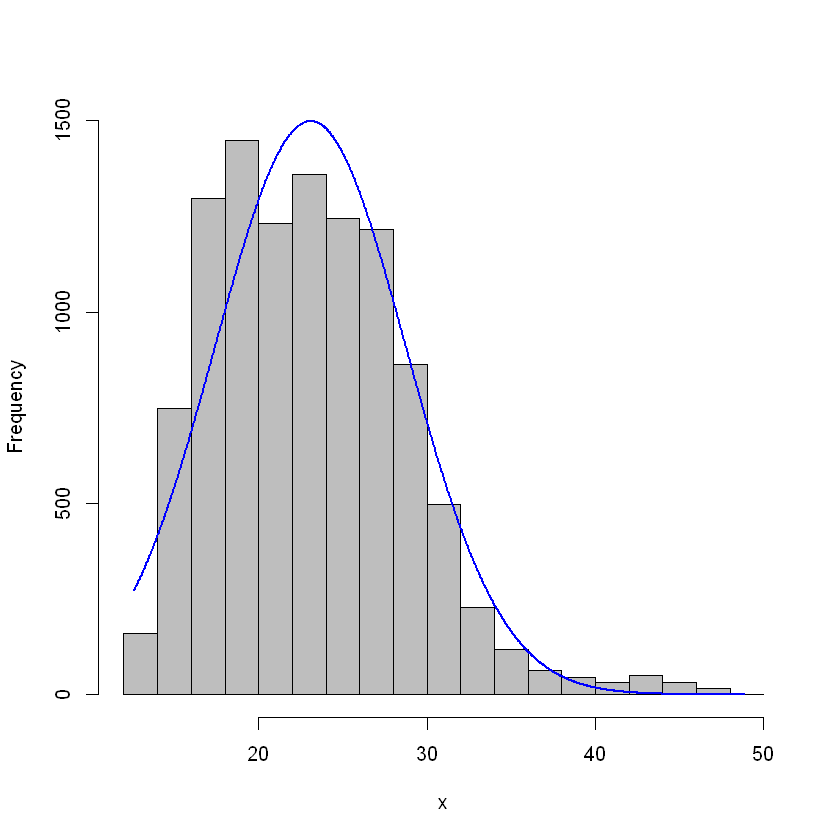

In [42]:
# выводим гистограмму распределения
# для преобразованной переменной CREDIT
plotNormalHistogram(var_cube)

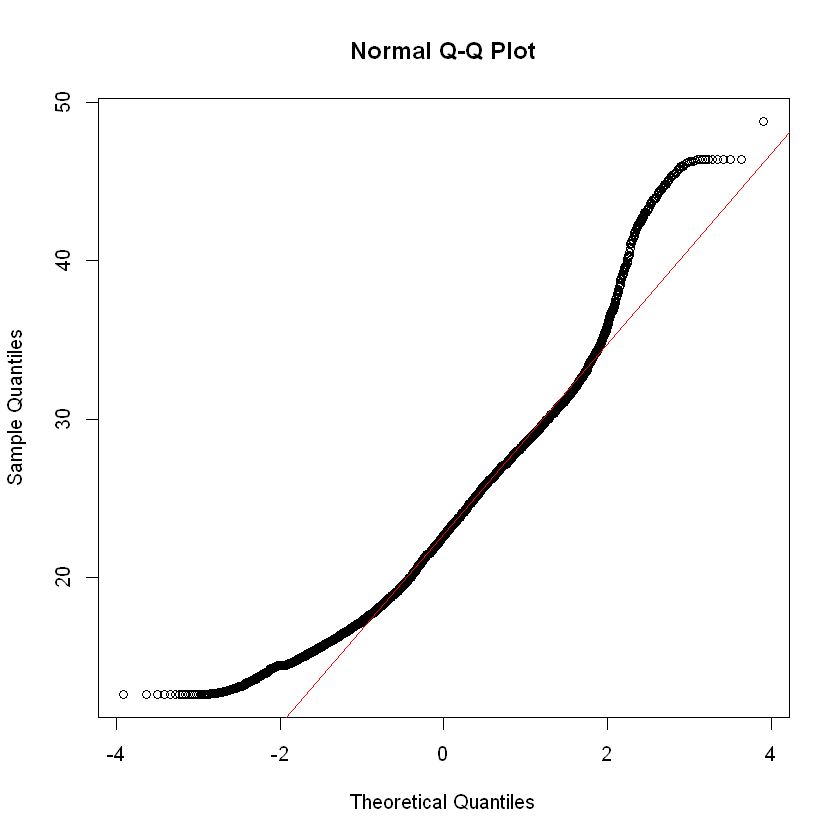

In [43]:
# выводим график квантиль-квантиль
# для преобразованной переменной CREDIT
qqnorm(var_cube,
       ylab="Sample Quantiles")
qqline(var_cube, 
       col="red")

In [44]:
# вычисляем лямбду преобразования Бокса-Кокса
# с помощью функции powerTransform пакета car
powerTransform(training$CREDIT)

Estimated transformation parameters 
training$CREDIT 
    -0.04163767 

In [45]:
# выполняем преобразование с помощью вычисленной лямбда,
# используя функцию bcPower пакета car
trans_var <-bcPower(training$CREDIT, -0.04163767)

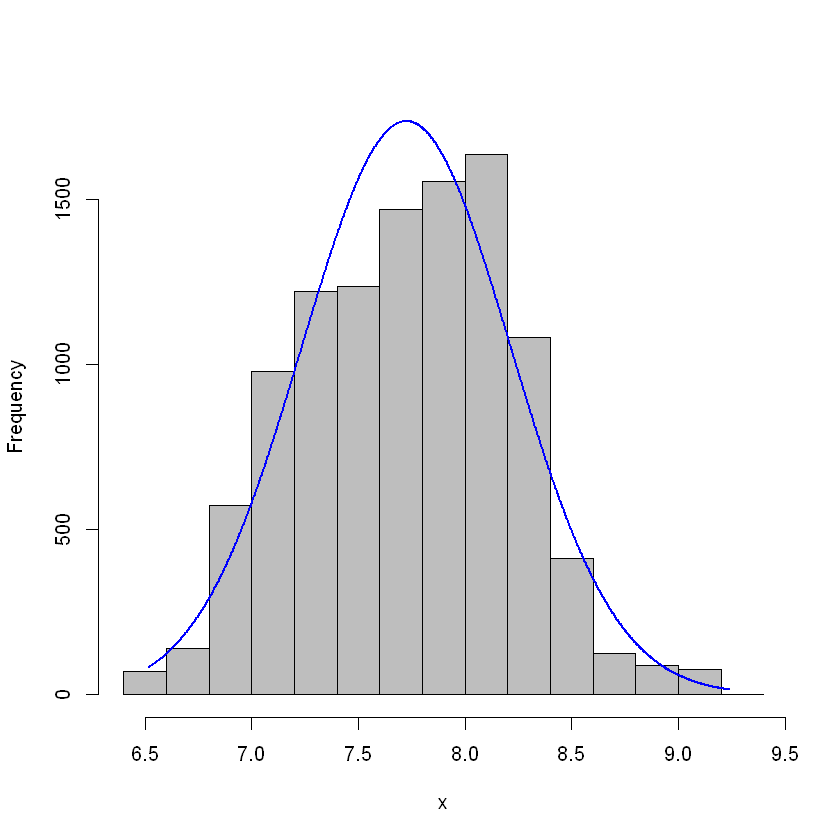

In [46]:
# выводим гистограмму распределения
# для преобразованной переменной CREDIT
plotNormalHistogram(trans_var)

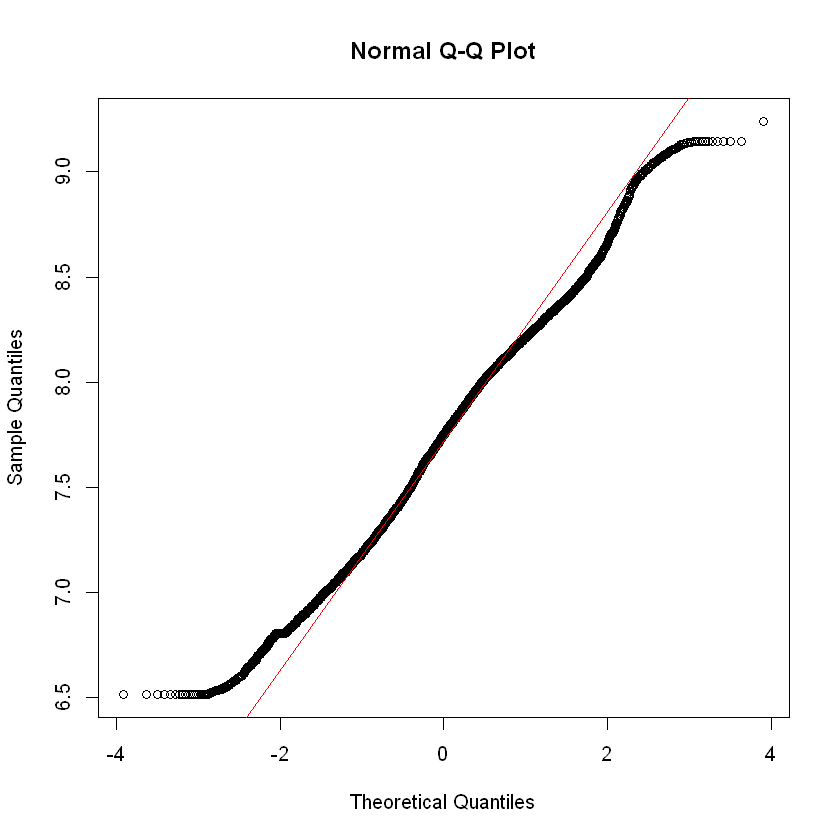

In [47]:
# выводим график квантиль-квантиль
# для преобразованной переменной CREDIT
qqnorm(trans_var,
       ylab="Sample Quantiles")
qqline(trans_var, 
       col="red")

In [48]:
# пишем функцию, создающую новые переменные
newFeaturesData <- 
  function(data) {
    data <- 
      data %>% mutate(
        PERSONAL_INCOME_INT = cut(PERSONAL_INCOME, 
                                  c(0,5000,10000,20000,50000,max(PERSONAL_INCOME))),
        FAMILY_INCOME_V2 = factor(FAMILY_INCOME, labels = levels(PERSONAL_INCOME_INT)),
        PERSONAL_FAMILY_INCOME = as.factor(
          ifelse(PERSONAL_INCOME_INT == FAMILY_INCOME_V2, 1, 0)
        ),
        PERSONAL_INCOME_INT = NULL, FAMILY_INCOME_V2 = NULL,
        PERSONAL_INCOME_LOG = log(PERSONAL_INCOME+0.01),
        CHILD_DEPENDANTS = CHILD_TOTAL/(CHILD_TOTAL+DEPENDANTS),
        CHILD_DEPENDANTS = ifelse(is.nan(CHILD_DEPENDANTS), 0, CHILD_DEPENDANTS),
        AUTO_FOR_FL = as.factor(ifelse(AUTO_RUS_FL == 0 & OWN_AUTO > 0, 1, 0)),
        CREDIT2=log(CREDIT),
        WORK_TIME2=log(WORK_TIME+0.01),
        FACT_LIVING_TERM=log(FACT_LIVING_TERM+0.01),
        PAYMENT = CREDIT/TERM,
        PTI = PAYMENT/PERSONAL_INCOME,
        LOAN_AVG_DLQ_AMT=log(LOAN_AVG_DLQ_AMT+0.01),
        FST_SHARE = FST_PAYMENT/(FST_PAYMENT+CREDIT),
        LOAN_SHARE_CLOSED = LOAN_NUM_CLOSED/LOAN_NUM_TOTAL,
        AVR_NUM_PAYM = LOAN_NUM_PAYM/LOAN_NUM_TOTAL,
        TERM_ON_AVR_NUM = TERM/AVR_NUM_PAYM,
        LOAN_SHARE_DLQ = LOAN_DLQ_NUM/LOAN_NUM_PAYM,
        DLQ_TIME = LOAN_MAX_DLQ/LOAN_DLQ_NUM,
        PERSONAL_INCOME = NULL,
        DLQ_TIME = ifelse(is.nan(DLQ_TIME), 0, DLQ_TIME),
        LOAN_MAX_DLQ_RANGE = abs((LOAN_MAX_DLQ_AMT - LOAN_AVG_DLQ_AMT)/LOAN_AVG_DLQ_AMT),
        LOAN_MAX_DLQ_RANGE = ifelse(is.nan(LOAN_MAX_DLQ_RANGE), 0, LOAN_MAX_DLQ_RANGE)
      )
    return(data)
  }

In [49]:
# применяем функцию, создающую новые переменные,
# к обучающей выборке
training <- newFeaturesData(training)

In [50]:
# смотрим типы переменных
str(training)

'data.frame':	10657 obs. of  65 variables:
 $ TARGET                    : Factor w/ 2 levels "noResponse","Response": 1 1 1 1 1 1 1 1 1 1 ...
 $ AGE                       : int  49 32 52 39 30 29 41 53 43 54 ...
 $ SOCSTATUS_WORK_FL         : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ SOCSTATUS_PENS_FL         : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ GENDER                    : Factor w/ 2 levels "0","1": 2 2 2 2 1 1 2 1 2 2 ...
 $ CHILD_TOTAL               : int  2 3 4 1 0 0 0 2 0 2 ...
 $ DEPENDANTS                : int  1 3 0 1 0 0 0 0 0 0 ...
 $ EDUCATION                 : Factor w/ 5 levels "Высшее или несколько высших",..: 5 4 3 1 4 4 4 1 5 5 ...
 $ MARITAL_STATUS            : Factor w/ 5 levels "Вдовец/Вдова",..: 5 5 5 5 5 2 5 5 5 3 ...
 $ GEN_INDUSTRY              : Factor w/ 24 levels "Банк/Финансы",..: 20 20 5 11 2 20 17 4 11 11 ...
 $ GEN_TITLE                 : Factor w/ 11 levels "Высококвалифиц. специалист",..: 6 6 11 9 11 11 6 7 11 10 ...
 $ O

In [51]:
# применяем функцию, укрупняющую редкие
# категории, к обучающей выборке
testing <- replaceRareClass(testing)

In [52]:
# применяем функцию, обрабатывающую выбросы,
# к тестовой выборке
testing <- replaceOutlier(testing)

In [53]:
# смотрим количество пропусков по каждой переменной
# в тестовой выборке
sapply(testing, function(x) sum(is.na(x)))

TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_ADDRESS_PROVINCE                TP_PROVINCE 
                         0                          0 
                 REGION_NM                REG_FACT_FL 
                         0                          0 
              FACT_POST_FL                REG_POST_FL 
                         0                          0 
          REG_FACT_POST_FL        REG_FACT_POST_TP_FL 
                         0                          0 
            FL_PRESENCE_FL                   OWN_AUTO 
                         0                          0 
               AUTO_RUS_FL             HS_PRESENCE_FL 
                         0                          0 
           COT_PRESENCE_FL            GAR_PRESENCE_FL 
                         0                          0 
          LAND_PRESENCE_FL                     CREDIT 
                         0                          0 
                      TERM                FST_PAYMENT 
                         0                          0 
           GPF_DOCUMENT_FL           FACT_LIVING_TERM 
                         0                          5 
                 WORK_TIME              FACT_PHONE_FL 
                       417                          0 
              REG_PHONE_FL               GEN_PHONE_FL 
                         0                          0 
            LOAN_NUM_TOTAL            LOAN_NUM_CLOSED 
                         0                          0 
             LOAN_NUM_PAYM               LOAN_DLQ_NUM 
                         0                          0 
              LOAN_MAX_DLQ           LOAN_AVG_DLQ_AMT 
                         0                          0 
          LOAN_MAX_DLQ_AMT PREVIOUS_CARD_NUM_UTILIZED 
                         0                          0 
                FACT_TP_FL 
                         0

In [54]:
# импутируем пропуски в количественных 
# переменных медианами
testing[sapply(testing, is.numeric)] <- lapply(testing[sapply(testing,  
                                                              is.numeric)], function(x) 
                                                                ifelse(is.na(x), 
                                                                       median(x, na.rm = TRUE), x))

In [55]:
# смотрим количество пропусков по каждой переменной
# в тестовой выборке
sapply(testing, function(x) sum(is.na(x)))

TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_ADDRESS_PROVINCE                TP_PROVINCE 
                         0                          0 
                 REGION_NM                REG_FACT_FL 
                         0                          0 
              FACT_POST_FL                REG_POST_FL 
                         0                          0 
          REG_FACT_POST_FL        REG_FACT_POST_TP_FL 
                         0                          0 
            FL_PRESENCE_FL                   OWN_AUTO 
                         0                          0 
               AUTO_RUS_FL             HS_PRESENCE_FL 
                         0                          0 
           COT_PRESENCE_FL            GAR_PRESENCE_FL 
                         0                          0 
          LAND_PRESENCE_FL                     CREDIT 
                         0                          0 
                      TERM                FST_PAYMENT 
                         0                          0 
           GPF_DOCUMENT_FL           FACT_LIVING_TERM 
                         0                          0 
                 WORK_TIME              FACT_PHONE_FL 
                         0                          0 
              REG_PHONE_FL               GEN_PHONE_FL 
                         0                          0 
            LOAN_NUM_TOTAL            LOAN_NUM_CLOSED 
                         0                          0 
             LOAN_NUM_PAYM               LOAN_DLQ_NUM 
                         0                          0 
              LOAN_MAX_DLQ           LOAN_AVG_DLQ_AMT 
                         0                          0 
          LOAN_MAX_DLQ_AMT PREVIOUS_CARD_NUM_UTILIZED 
                         0                          0 
                FACT_TP_FL 
                         0

In [56]:
# применяем функцию, создающую новые переменные,
# к тестовой выборке
testing <- newFeaturesData(testing)

In [57]:
# смотрим типы переменных
str(testing)

'data.frame':	4566 obs. of  65 variables:
 $ TARGET                    : Factor w/ 2 levels "noResponse","Response": 1 2 1 2 1 1 1 1 1 1 ...
 $ AGE                       : int  35 62 42 31 40 43 38 38 31 54 ...
 $ SOCSTATUS_WORK_FL         : Factor w/ 2 levels "0","1": 2 1 2 2 2 2 2 2 2 2 ...
 $ SOCSTATUS_PENS_FL         : Factor w/ 2 levels "0","1": 1 2 1 1 1 1 1 1 1 1 ...
 $ GENDER                    : Factor w/ 2 levels "0","1": 1 1 2 2 1 2 1 1 1 2 ...
 $ CHILD_TOTAL               : int  1 3 1 1 1 2 0 4 1 2 ...
 $ DEPENDANTS                : int  1 0 1 1 1 2 0 4 1 0 ...
 $ EDUCATION                 : Factor w/ 5 levels "Высшее или несколько высших",..: 1 4 5 5 5 5 1 5 5 1 ...
 $ MARITAL_STATUS            : Factor w/ 5 levels "Вдовец/Вдова",..: 4 2 5 5 5 5 3 5 5 5 ...
 $ GEN_INDUSTRY              : Factor w/ 24 levels "Банк/Финансы",..: 3 8 20 3 3 8 1 3 8 20 ...
 $ GEN_TITLE                 : Factor w/ 11 levels "Высококвалифиц. специалист",..: 11 6 11 11 6 6 11 7 6 11 ...
 $ ORG_TP_

In [58]:
# настраиваем параметры решетчатого поиска
set.seed(15111)
ctrl = trainControl(method = "repeatedcv", number=5, repeats=1, classProbs=T, 
                    summaryFunction = twoClassSummary)
gridSet <- expand.grid(
  .mtry = c(20, 24, 28, 32),
  .min.node.size =c(100, 110),
  .splitrule = "gini"
)

modelWeights <- ifelse(training$TARGET == "noResponse",
                       (1/prop.table(table(training$TARGET))[1]) * 0.5,
                       (1/prop.table(table(training$TARGET))[2]) * 0.5)

modelInfo <- list(label = "Random Forest",
                  library = c("e1071", "ranger", "dplyr"),
                  check = function(pkg) {
                    requireNamespace("ranger")
                    current <- packageDescription("ranger")$Version
                    expected <- "0.8.0"
                    if(compareVersion(current, expected) < 0)
                      stop("This modeling workflow requires ranger version ",
                           expected, "or greater.", call. = FALSE)
                  },
                  loop = NULL,
                  type = c("Classification", "Regression"),
                  parameters = data.frame(parameter = c("mtry", "splitrule", "min.node.size"),
                                          class = c("numeric", "character", "numeric"),
                                          label = c("#Randomly Selected Predictors", 
                                                    "Splitting Rule", 
                                                    "Minimal Node Size")),
                  grid = function(x, y, len = NULL, search = "grid") {
                    if(search == "grid") {
                      srule <-
                        if (is.factor(y))
                          "gini"
                      else
                        "variance"
                      out <- expand.grid(mtry = 
                                           caret::var_seq(p = ncol(x),
                                                          classification = is.factor(y),
                                                          len = len),
                                         min.node.size = ifelse( is.factor(y), 1, 5), 
                                         splitrule = c(srule, "extratrees"))
                    } else {
                      srules <- if (is.factor(y))
                        c("gini", "extratrees")
                      else
                        c("variance", "extratrees", "maxstat")
                      out <-
                        data.frame(
                          min.node.size= sample(1:(min(20,nrow(x))), size = len, replace = TRUE), 
                          mtry = sample(1:ncol(x), size = len, replace = TRUE),
                          splitrule = sample(srules, size = len, replace = TRUE)
                        )
                    }
                    out
                  },
                  fit = function(x, y, wts, param, lev, last, classProbs, ...) {
                    if((!is.data.frame(x))||dplyr::is.tbl(x)) x <- as.data.frame(x)
                    x$.outcome <- y
                    if(!is.null(wts)) {
                      out <- ranger::ranger(dependent.variable.name = ".outcome", 
                                            data = x, 
                                            mtry = param$mtry, 
                                            min.node.size = param$min.node.size,
                                            splitrule = as.character(param$splitrule),
                                            write.forest = TRUE,
                                            probability = classProbs, 
                                            case.weights = wts, 
                                            ...)
                    } else {
                      out <- ranger::ranger(dependent.variable.name = ".outcome", 
                                            data = x, 
                                            mtry = param$mtry, 
                                            min.node.size = param$min.node.size,
                                            splitrule = as.character(param$splitrule),
                                            write.forest = TRUE,
                                            probability = classProbs, 
                                            ...)
                    }
                    ## in case the resampling method is "oob"
                    if(!last) out$y <- y
                    out
                  },
                  predict = function(modelFit, newdata, submodels = NULL) {
                    if((!is.data.frame(newdata))||dplyr::is.tbl(newdata)) newdata <- as.data.frame(newdata)
                    out <- predict(modelFit, newdata)$predictions
                    if(!is.null(modelFit$obsLevels) & modelFit$treetype == "Probability estimation") {
                      out <- colnames(out)[apply(out, 1, which.max)]
                    }
                    out
                  },
                  prob = function(modelFit, newdata, submodels = NULL) {
                    if(!is.data.frame(newdata)) newdata <- as.data.frame(newdata)
                    predict(modelFit, newdata)$predictions
                  },
                  predictors = function(x, ...) {
                    var_index <- sort(unique(unlist(lapply(x$forest$split.varIDs, function(x) x))))
                    var_index <-var_index[var_index > 0]
                    x$forest$independent.variable.names[var_index]
                  },
                  varImp = function(object, ...){
                    if(length(object$variable.importance) == 0)
                      stop("No importance values available")
                    imps <- ranger:::importance(object)
                    out <- data.frame(Overall = as.vector(imps))
                    rownames(out) <- names(imps)
                    out
                  },
                  levels = function(x) {
                    if(x$treetype == "Probability estimation") {
                      out <- colnames(x$predictions)
                    } else {
                      if(x$treetype == "Classification") {
                        out <- levels(x$predictions)
                      } else out <- NULL
                    }
                    out
                  },
                  oob = function(x) {
                    postResample(x$predictions, x$y)
                  },
                  tags = c("Random Forest", "Ensemble Model", "Bagging",
                           "Implicit Feature Selection", "Accepts Case Weights"),
                  sort = function(x) x[order(x[,1]),])


In [59]:
# запускаем решетчатый поиск, перебираем 
# параметры mtry и min.node.size пакета
# ranger (то есть количество случайно
# обираемых предикторов для разбиения и
# минимальное количество наблюдений в 
# терминальном узле для случайного леса)
ranger_gridsearch <- train(TARGET ~ ., data = training, num.trees=800,
                           method = modelInfo, importance = "impurity",
                           weights = modelWeights,
                           metric = "ROC", 
                           trControl = ctrl, tuneGrid = gridSet)

# печатаем результаты решетчатого поиска
print(ranger_gridsearch)


Attaching package: 'e1071'

The following object is masked from 'package:Hmisc':

    impute

The following object is masked from 'package:imputeMissings':

    impute



Random Forest 

10657 samples
   64 predictor
    2 classes: 'noResponse', 'Response' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 8525, 8526, 8526, 8526, 8525 
Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
  20    100            0.6913436  0.8378776  0.3640627
  20    110            0.6930344  0.8275455  0.3821917
  24    100            0.6917697  0.8380914  0.3680060
  24    110            0.6923547  0.8296763  0.3798170
  28    100            0.6914203  0.8397952  0.3616912
  28    110            0.6919427  0.8310604  0.3829728
  32    100            0.6915229  0.8423519  0.3640534
  32    110            0.6930917  0.8322329  0.3829697

Tuning parameter 'splitrule' was held constant at a value of gini
ROC was used to select the optimal model using  the largest value.
The final values used for the model were mtry = 32, splitrule = gini
 and min.node.size = 110.


In [60]:
# преобразовываем весь обучающий набор и итоговый тестовый набор
# перевыгружаем данные
OTPset <- read.csv2("Credit_OTP.csv", stringsAsFactors = F)
OTPset_test <- read.csv2("Credit_OTP_new.csv", stringsAsFactors = F)

In [61]:
# удаляем переменную AGREEMENT_RK
OTPset$AGREEMENT_RK = NULL

# применяем функции предобработки
OTPset <- preProcessData(OTPset)

# применяем функцию, укрупняющую редкие
# категории
OTPset <- replaceRareClass(OTPset)

# применяем функцию, обрабатывающую выбросы
OTPset <- replaceOutlier(OTPset)

# смотрим количество пропусков по каждой переменной
sapply(OTPset, function(x) sum(is.na(x)))

TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_ADDRESS_PROVINCE                TP_PROVINCE 
                         0                          0 
                 REGION_NM                REG_FACT_FL 
                         0                          0 
              FACT_POST_FL                REG_POST_FL 
                         0                          0 
          REG_FACT_POST_FL        REG_FACT_POST_TP_FL 
                         0                          0 
            FL_PRESENCE_FL                   OWN_AUTO 
                         0                          0 
               AUTO_RUS_FL             HS_PRESENCE_FL 
                         0                          0 
           COT_PRESENCE_FL            GAR_PRESENCE_FL 
                         0                          0 
          LAND_PRESENCE_FL                     CREDIT 
                         0                          0 
                      TERM                FST_PAYMENT 
                         0                          0 
           GPF_DOCUMENT_FL           FACT_LIVING_TERM 
                         0                         16 
                 WORK_TIME              FACT_PHONE_FL 
                      1381                          0 
              REG_PHONE_FL               GEN_PHONE_FL 
                         0                          0 
            LOAN_NUM_TOTAL            LOAN_NUM_CLOSED 
                         0                          0 
             LOAN_NUM_PAYM               LOAN_DLQ_NUM 
                         0                          0 
              LOAN_MAX_DLQ           LOAN_AVG_DLQ_AMT 
                         0                          0 
          LOAN_MAX_DLQ_AMT PREVIOUS_CARD_NUM_UTILIZED 
                         0                          0 
                FACT_TP_FL 
                         0

In [62]:
# импутируем пропуски в количественных 
# переменных медианами
OTPset[sapply(OTPset, is.numeric)] <- lapply(OTPset[sapply(OTPset,  
                                                           is.numeric)], function(x) 
                                                             ifelse(is.na(x), 
                                                                    median(x, na.rm = TRUE), x))

In [63]:
# смотрим количество пропусков по каждой переменной
sapply(OTPset, function(x) sum(is.na(x)))

TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_ADDRESS_PROVINCE                TP_PROVINCE 
                         0                          0 
                 REGION_NM                REG_FACT_FL 
                         0                          0 
              FACT_POST_FL                REG_POST_FL 
                         0                          0 
          REG_FACT_POST_FL        REG_FACT_POST_TP_FL 
                         0                          0 
            FL_PRESENCE_FL                   OWN_AUTO 
                         0                          0 
               AUTO_RUS_FL             HS_PRESENCE_FL 
                         0                          0 
           COT_PRESENCE_FL            GAR_PRESENCE_FL 
                         0                          0 
          LAND_PRESENCE_FL                     CREDIT 
                         0                          0 
                      TERM                FST_PAYMENT 
                         0                          0 
           GPF_DOCUMENT_FL           FACT_LIVING_TERM 
                         0                          0 
                 WORK_TIME              FACT_PHONE_FL 
                         0                          0 
              REG_PHONE_FL               GEN_PHONE_FL 
                         0                          0 
            LOAN_NUM_TOTAL            LOAN_NUM_CLOSED 
                         0                          0 
             LOAN_NUM_PAYM               LOAN_DLQ_NUM 
                         0                          0 
              LOAN_MAX_DLQ           LOAN_AVG_DLQ_AMT 
                         0                          0 
          LOAN_MAX_DLQ_AMT PREVIOUS_CARD_NUM_UTILIZED 
                         0                          0 
                FACT_TP_FL 
                         0

In [64]:
# применяем функцию, создающую новые переменные
OTPset <- newFeaturesData(OTPset)

In [65]:
# удаляем переменную AGREEMENT_RK
OTPset_test$AGREEMENT_RK = NULL

# применяем функции предобработки
OTPset_test <- preProcessDataTest(OTPset_test)

# применяем функцию, укрупняющую редкие
# категории
OTPset_test <- replaceRareClass(OTPset_test)

# применяем функцию, обрабатывающую выбросы
OTPset_test <- replaceOutlier(OTPset_test)

# смотрим количество пропусков по каждой переменной
sapply(OTPset_test, function(x) sum(is.na(x)))

TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_ADDRESS_PROVINCE                TP_PROVINCE 
                         0                          0 
                 REGION_NM                REG_FACT_FL 
                         0                          0 
              FACT_POST_FL                REG_POST_FL 
                         0                          0 
          REG_FACT_POST_FL        REG_FACT_POST_TP_FL 
                         0                          0 
            FL_PRESENCE_FL                   OWN_AUTO 
                         0                          0 
               AUTO_RUS_FL             HS_PRESENCE_FL 
                         0                          0 
           COT_PRESENCE_FL            GAR_PRESENCE_FL 
                         0                          0 
          LAND_PRESENCE_FL                     CREDIT 
                         0                          0 
                      TERM                FST_PAYMENT 
                         0                          0 
           GPF_DOCUMENT_FL           FACT_LIVING_TERM 
                         0                         15 
                 WORK_TIME              FACT_PHONE_FL 
                         7                          0 
              REG_PHONE_FL               GEN_PHONE_FL 
                         0                          0 
            LOAN_NUM_TOTAL            LOAN_NUM_CLOSED 
                         0                          0 
             LOAN_NUM_PAYM               LOAN_DLQ_NUM 
                         0                          0 
              LOAN_MAX_DLQ           LOAN_AVG_DLQ_AMT 
                         0                          0 
          LOAN_MAX_DLQ_AMT PREVIOUS_CARD_NUM_UTILIZED 
                         0                          0 
                FACT_TP_FL 
                         0

In [66]:
# импутируем пропуски в количественных 
# переменных медианами
OTPset_test[sapply(OTPset_test, is.numeric)] <- lapply(OTPset_test[sapply(OTPset_test,  
                                                                          is.numeric)], function(x) 
                                                                            ifelse(is.na(x), 
                                                                                   median(x, na.rm = TRUE), x))

In [67]:
# смотрим количество пропусков по каждой переменной
sapply(OTPset_test, function(x) sum(is.na(x)))

TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_ADDRESS_PROVINCE                TP_PROVINCE 
                         0                          0 
                 REGION_NM                REG_FACT_FL 
                         0                          0 
              FACT_POST_FL                REG_POST_FL 
                         0                          0 
          REG_FACT_POST_FL        REG_FACT_POST_TP_FL 
                         0                          0 
            FL_PRESENCE_FL                   OWN_AUTO 
                         0                          0 
               AUTO_RUS_FL             HS_PRESENCE_FL 
                         0                          0 
           COT_PRESENCE_FL            GAR_PRESENCE_FL 
                         0                          0 
          LAND_PRESENCE_FL                     CREDIT 
                         0                          0 
                      TERM                FST_PAYMENT 
                         0                          0 
           GPF_DOCUMENT_FL           FACT_LIVING_TERM 
                         0                          0 
                 WORK_TIME              FACT_PHONE_FL 
                         0                          0 
              REG_PHONE_FL               GEN_PHONE_FL 
                         0                          0 
            LOAN_NUM_TOTAL            LOAN_NUM_CLOSED 
                         0                          0 
             LOAN_NUM_PAYM               LOAN_DLQ_NUM 
                         0                          0 
              LOAN_MAX_DLQ           LOAN_AVG_DLQ_AMT 
                         0                          0 
          LOAN_MAX_DLQ_AMT PREVIOUS_CARD_NUM_UTILIZED 
                         0                          0 
                FACT_TP_FL 
                         0

In [68]:
# применяем функцию, создающую новые переменные
OTPset_test <- newFeaturesData(OTPset_test)

In [69]:
# загружаем библиотеку h2o, 
# перед загрузкой библиотеки h2o убедитесь, что библиотека h2o установлена 
# (сначала установите Java SE Development Kit 8, обратите внимание, 
# 9-я версия H2O не поддерживается, а затем после установки Java 
# установите пакет h2o с помощью команды
# install.packages("h2o", type="source", repos=(c("http://h2o-release.s3.amazonaws.com/h2o/latest_stable_R"))) и
# затем загрузите библиотеку)

library(h2o)
h2o.init(nthreads=-1, max_mem_size = "8G")


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following object is masked from 'package:pROC':

    var

The following objects are masked from 'package:memisc':

    %in%, as.factor

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 hours 32 minutes 
    H2O cluster timezone:       Europe/Moscow 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.17.0.4153 
    H2O cluster version age:    21 days, 17 hours and 9 minutes  
    H2O cluster name:           H2O_started_from_R_Gewissta_djm718 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   7.03 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.2 (2017-09-28) 



In [70]:
# смотрим датафреймы перед преобразованием
# во фреймы H2O, обратите внимание, h2o
# не умеет обрабатывать упорядоченные факторы
# (ordered factors)
str(OTPset)
str(OTPset_test)

'data.frame':	15223 obs. of  65 variables:
 $ TARGET                    : Factor w/ 2 levels "noResponse","Response": 1 1 1 1 1 1 1 1 1 1 ...
 $ AGE                       : int  49 32 52 39 30 29 35 41 53 43 ...
 $ SOCSTATUS_WORK_FL         : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ SOCSTATUS_PENS_FL         : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ GENDER                    : Factor w/ 2 levels "0","1": 2 2 2 2 1 1 1 2 1 2 ...
 $ CHILD_TOTAL               : int  2 3 4 1 0 0 1 0 2 0 ...
 $ DEPENDANTS                : int  1 3 0 1 0 0 1 0 0 0 ...
 $ EDUCATION                 : Factor w/ 5 levels "Высшее или несколько высших",..: 5 4 3 1 4 4 1 4 1 5 ...
 $ MARITAL_STATUS            : Factor w/ 5 levels "Вдовец/Вдова",..: 5 5 5 5 5 2 4 5 5 5 ...
 $ GEN_INDUSTRY              : Factor w/ 24 levels "Банк/Финансы",..: 20 20 5 11 2 20 3 17 4 11 ...
 $ GEN_TITLE                 : Factor w/ 11 levels "Высококвалифиц. специалист",..: 6 6 11 9 11 11 11 6 7 11 ...
 $ OR

In [71]:
# выполняем преобразование во фреймы h2o
train <- as.h2o(OTPset)
valid <- as.h2o(OTPset_test)

  |======================================================================| 100%
  |======================================================================| 100%


In [72]:
# взглянем на обучающий фрейм h2o
str(train)

Class 'H2OFrame' <environment: 0x00000000085ec400> 
 - attr(*, "op")= chr "Parse"
 - attr(*, "id")= chr "OTPset"
 - attr(*, "eval")= logi FALSE
 - attr(*, "nrow")= int 15223
 - attr(*, "ncol")= int 65
 - attr(*, "types")=List of 65
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "real"
  ..$ : chr "int"
  ..$ : chr "real"
  ..$ : chr "enum"
  ..$ : chr "real"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enu

In [73]:
# строим модель логистической регрессии
glm1 <- h2o.glm(family= "binomial", training_frame = train, validation_frame = valid, 
               x=c(2:65), y=1, seed = 1000000)

# смотрим модель
summary(glm1)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: glm
Model Key:  GLM_model_R_1516277274455_1454 
GLM Model: summary
    family  link                                regularization
1 binomial logit Elastic Net (alpha = 0.5, lambda = 6.752E-5 )
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                        429                         270                    5
  training_frame
1         OTPset

H2OBinomialMetrics: glm
** Reported on training data. **

MSE:  0.09624002
RMSE:  0.3102258
LogLoss:  0.3268334
Mean Per-Class Error:  0.4992095
AUC:  0.7338368
Gini:  0.4676737
R^2:  0.08222367
Residual Deviance:  9950.769
AIC:  10492.77

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response          3       1809 0.998344   =1809/1812
noResponse        1      13410 0.000075     =1/13411
Totals            4   

In [74]:
# строим модель логистической регрессии 
# с перебором lambda - силы штрафа 
glm2 <- h2o.glm(family= "binomial", training_frame = train, validation_frame = valid, 
               x=c(2:65), y=1, seed = 1000000, lambda_search = TRUE)

# смотрим модель
summary(glm2)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: glm
Model Key:  GLM_model_R_1516277274455_1457 
GLM Model: summary
    family  link                                regularization
1 binomial logit Elastic Net (alpha = 0.5, lambda = 5.873E-4 )
                                                                  lambda_search
1 nlambda = 100, lambda.max = 0.06752, lambda.min = 5.873E-4, lambda.1se = -1.0
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                        429                         148                   74
  training_frame
1         OTPset

H2OBinomialMetrics: glm
** Reported on training data. **

MSE:  0.09723794
RMSE:  0.31183
LogLoss:  0.3306722
Mean Per-Class Error:  0.4990081
AUC:  0.7243216
Gini:  0.4486432
R^2:  0.07270719
Residual Deviance:  10067.64
AIC:  10365.64

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noR

In [75]:
# выполняем решетчатый поиск с перебором alpha и lambda,
# alpha задает тип регуляризации: значение 1 соответствует 
# l1-регуляризации (лассо), значение 0 соответствует 
# l2-регуляризации (гребневой регрессии), 
# промежуточное значение соответствует 
# комбинации штрафов l1 и l2 (эластичной сети),
# lambda задает силу штрафа
hyper_parameters <- list(alpha = c(0, 0.2, 0.4, 0.6, 1))
glm_grid <- h2o.grid(algorithm = "glm", grid_id = "glm_grid", 
                     hyper_params = hyper_parameters, 
                     training_frame = train, validation_frame = valid, x = c(2:65), y = "TARGET",
                     lambda_search=TRUE, family = "binomial", seed = 1000000)

# выводим результаты решетчатого поиска
summary(glm_grid)

  |======================================================================| 100%
H2O Grid Details

Grid ID: glm_grid 
Used hyper parameters: 
  -  alpha 
Number of models: 5 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing logloss
  alpha        model_ids             logloss
1 [0.0] glm_grid_model_0 0.33400908906992804
2 [0.2] glm_grid_model_1  0.3343831298951155
3 [0.6] glm_grid_model_3 0.33452255649363594
4 [0.4] glm_grid_model_2 0.33454320273122495
5 [1.0] glm_grid_model_4 0.33456788239469304
H2O Grid Summary

Grid ID: glm_grid 
Used hyper parameters: 
  -  alpha 
Number of models: 5 
  -  glm_grid_model_0 
  -  glm_grid_model_1 
  -  glm_grid_model_3 
  -  glm_grid_model_2 
  -  glm_grid_model_4 

Number of failed models: 0 


In [76]:
# сортируем по AUC
sorted_glm_grid <- h2o.getGrid("glm_grid", sort_by = "auc", decreasing = TRUE)

# выводим результаты решетчатого поиска,
# отсортировав по убыванию AUC
sorted_glm_grid

H2O Grid Details

Grid ID: glm_grid 
Used hyper parameters: 
  -  alpha 
Number of models: 5 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  alpha        model_ids                auc
1 [0.0] glm_grid_model_0 0.7097814155449415
2 [0.2] glm_grid_model_1 0.7084343030829353
3 [0.6] glm_grid_model_3 0.7081498914459401
4 [0.4] glm_grid_model_2 0.7080280503690838
5 [1.0] glm_grid_model_4 0.7079873860182371

In [77]:
# снова выполняем решетчатый поиск, но теперь дополнительно
# зададим список предикторов для рассмотрения парных
# взаимодействий
glm_grid2 <- h2o.grid(algorithm = "glm", grid_id = "glm_grid2", 
                     hyper_params = hyper_parameters, 
                     training_frame = train, validation_frame = valid, x = c(2:65), y = "TARGET",
                     lambda_search=TRUE, family = "binomial",
                     interactions=c("GENDER", "EDUCATION", "REGION_NM", "REG_ADDRESS_PROVINCE"),
                     seed = 1000000)

  |======================================================================| 100%


In [78]:
# выводим результаты решетчатого поиска
summary(glm_grid2)

H2O Grid Details

Grid ID: glm_grid2 
Used hyper parameters: 
  -  alpha 
Number of models: 5 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing logloss
  alpha         model_ids             logloss
1 [0.0] glm_grid2_model_0  0.3339011088701826
2 [0.2] glm_grid2_model_1  0.3344306897999521
3 [0.4] glm_grid2_model_2  0.3346195730829653
4 [0.6] glm_grid2_model_3  0.3348236978659521
5 [1.0] glm_grid2_model_4 0.33527480262680387
H2O Grid Summary

Grid ID: glm_grid2 
Used hyper parameters: 
  -  alpha 
Number of models: 5 
  -  glm_grid2_model_0 
  -  glm_grid2_model_1 
  -  glm_grid2_model_2 
  -  glm_grid2_model_3 
  -  glm_grid2_model_4 

Number of failed models: 0 


In [79]:
# сортируем по AUC
sorted_glm_grid2 <- h2o.getGrid("glm_grid2",
                                sort_by = "auc", decreasing = TRUE)

In [80]:
# выводим результаты решетчатого поиска,
# отсортировав по убыванию AUC
sorted_glm_grid2

H2O Grid Details

Grid ID: glm_grid2 
Used hyper parameters: 
  -  alpha 
Number of models: 5 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  alpha         model_ids                auc
1 [0.0] glm_grid2_model_0  0.710637516283109
2 [0.2] glm_grid2_model_1  0.708300151975684
3 [0.4] glm_grid2_model_2 0.7075972210160659
4 [0.6] glm_grid2_model_3  0.706309856708641
5 [1.0] glm_grid2_model_4 0.7041607685627442

In [81]:
# записываем идентификатор наилучшей модели
best_model_id <- sorted_glm_grid2@model_ids[[1]]

In [82]:
# извлекаем наилучшую модель
best_model <- h2o.getModel(best_model_id)

In [83]:
# смотрим наилучшую модель
best_model

Model Details:

H2OBinomialModel: glm
Model ID:  glm_grid2_model_0 
GLM Model: summary
    family  link              regularization
1 binomial logit Ridge ( lambda = 0.008086 )
                                                                lambda_search
1 nlambda = 30, lambda.max = 3.3762, lambda.min = 0.008086, lambda.1se = -1.0
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                       1174                        1174                   50
  training_frame
1         OTPset

Coefficients: glm coefficients
                                                                                                                                                 names
1                                                                                                                                            Intercept
2                                  EDUCATION_REG_ADDRESS_PROVINCE.<0xC2FBF1F8E5E5> <0xE8EBE8> <0xEDE5F1EAEEEBFCEAEE> <0xE2FBF1F8E8F5>_<0xC0E4FB

In [84]:
# строим модель градиентного бустинга, перечислены 
# значения параметров по умолчанию: learn_rate -
# темп обучения, ntrees - количество деревьев (итераций),
# max_depth - глубина, min_rows - количество
# наблюдений в терминальном узле, sample_rate -
# процент отобранных строк для построения дерева,
# col_sample_rate - процент случайно отбираемых столбцов 
# для каждого разбиения узла, col_sample_rate_per_tree -
# процент случайно отбираемых столбцов для каждого дерева,
# col_sample_rate_per_tree - относительное изменение 
# отбора столбцов для каждого уровня дерева
gbm1 <- h2o.gbm(learn_rate=0.1, ntrees = 50, max_depth = 5, min_rows = 10,
                sample_rate = 1, col_sample_rate = 1,
                col_sample_rate_change_per_level = 1, 
                col_sample_rate_per_tree = 1,
                training_frame = train, validation_frame = valid, 
                x=c(2:65), y=1, seed = 1000000)

summary(gbm1)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: gbm
Model Key:  GBM_model_R_1516277274455_1460 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              50                       50               28051         5
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         5    5.00000         21         32    29.06000

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.07096962
RMSE:  0.2664012
LogLoss:  0.2462631
Mean Per-Class Error:  0.2842824
AUC:  0.9197517
Gini:  0.8395034

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response        805       1007 0.555740   =1007/1812
noResponse      172      13239 0.012825   =172/13411
Totals          977      14246 0.077449  =1179/15223

Maximum Metrics: Maximum metrics at their respective thresholds
                        

In [85]:
# попробуем уменьшить глубину
gbm2 <- h2o.gbm(learn_rate=0.1, ntrees = 50, max_depth = 2, min_rows = 10,
                sample_rate = 1, col_sample_rate = 1,
                col_sample_rate_change_per_level = 1, 
                col_sample_rate_per_tree = 1,
                training_frame = train, validation_frame = valid, 
                x=c(2:65), y=1, seed = 1000000)

summary(gbm2)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: gbm
Model Key:  GBM_model_R_1516277274455_1521 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              50                       50                6370         2
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         2    2.00000          4          4     4.00000

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.0956584
RMSE:  0.3092869
LogLoss:  0.3265525
Mean Per-Class Error:  0.4829066
AUC:  0.7557932
Gini:  0.5115864

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response         66       1746 0.963576   =1746/1812
noResponse       30      13381 0.002237    =30/13411
Totals           96      15127 0.116666  =1776/15223

Maximum Metrics: Maximum metrics at their respective thresholds
                        m

In [86]:
# теперь попробуем увеличить минимальное 
# количество наблюдений в листе
gbm3 <- h2o.gbm(learn_rate=0.1, ntrees = 50, max_depth = 2, min_rows = 115,
                sample_rate = 1, col_sample_rate = 1,
                col_sample_rate_change_per_level = 1, 
                col_sample_rate_per_tree = 1,
                training_frame = train, validation_frame = valid, 
                x=c(2:65), y=1, seed = 1000000)

summary(gbm3)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: gbm
Model Key:  GBM_model_R_1516277274455_1608 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              50                       50                6348         2
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         2    2.00000          3          4     3.98000

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.09577243
RMSE:  0.3094712
LogLoss:  0.3267426
Mean Per-Class Error:  0.4778426
AUC:  0.7561916
Gini:  0.5123832

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response         88       1724 0.951435   =1724/1812
noResponse       57      13354 0.004250    =57/13411
Totals          145      15078 0.116994  =1781/15223

Maximum Metrics: Maximum metrics at their respective thresholds
                        

In [87]:
# теперь попробуем уменьшить процент отбираемых 
# столбцов (вносим рандомизацию)
gbm4 <- h2o.gbm(learn_rate=0.1, ntrees = 50, max_depth = 2, min_rows = 115,
                sample_rate = 1, col_sample_rate = 0.14,
                col_sample_rate_change_per_level = 1, 
                col_sample_rate_per_tree = 1,
                training_frame = train, validation_frame = valid, 
                x=c(2:65), y=1, seed = 1000000)

summary(gbm4)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: gbm
Model Key:  GBM_model_R_1516277274455_1693 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              50                       50                6076         2
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         2    2.00000          3          4     3.98000

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.09703146
RMSE:  0.3114987
LogLoss:  0.3315712
Mean Per-Class Error:  0.477134
AUC:  0.7402354
Gini:  0.4804708

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response         93       1719 0.948675   =1719/1812
noResponse       75      13336 0.005592    =75/13411
Totals          168      15055 0.117848  =1794/15223

Maximum Metrics: Maximum metrics at their respective thresholds
                        m

In [88]:
# теперь попробуем уменьшить процент отбираемых 
# столбцов для каждого дерева (вносим рандомизацию)
gbm5 <- h2o.gbm(learn_rate=0.1, ntrees = 50, max_depth = 2, min_rows = 115,
                sample_rate = 1, col_sample_rate = 0.14,
                col_sample_rate_change_per_level = 1, 
                col_sample_rate_per_tree = 0.25,
                training_frame = train, validation_frame = valid, 
                x=c(2:65), y=1, seed = 1000000)

summary(gbm5)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: gbm
Model Key:  GBM_model_R_1516277274455_1790 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              50                       50                5742         2
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         2    2.00000          3          4     3.94000

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.09933499
RMSE:  0.3151745
LogLoss:  0.340144
Mean Per-Class Error:  0.4972257
AUC:  0.7176452
Gini:  0.4352903

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response         11       1801 0.993929   =1801/1812
noResponse        7      13404 0.000522     =7/13411
Totals           18      15205 0.118768  =1808/15223

Maximum Metrics: Maximum metrics at their respective thresholds
                        m

In [89]:
# возвращаемся к базовым параметрам, увеличиваем learn_rate
gbm6 <- h2o.gbm(learn_rate=0.2, ntrees = 50, max_depth = 2, min_rows = 115,
                sample_rate = 1, col_sample_rate = 0.14,
                col_sample_rate_change_per_level = 1, 
                col_sample_rate_per_tree = 0.25,
                training_frame = train, validation_frame = valid, 
                x=c(2:65), y=1, seed = 1000000)

summary(gbm6)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: gbm
Model Key:  GBM_model_R_1516277274455_1891 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              50                       50                5791         2
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         2    2.00000          3          4     3.96000

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.09718229
RMSE:  0.3117407
LogLoss:  0.3315596
Mean Per-Class Error:  0.4911997
AUC:  0.7296383
Gini:  0.4592766

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response         35       1777 0.980684   =1777/1812
noResponse       23      13388 0.001715    =23/13411
Totals           58      15165 0.118242  =1800/15223

Maximum Metrics: Maximum metrics at their respective thresholds
                        

In [90]:
# поскольку мы немного увеличили learn_rate, можно 
# немного снизить количество итераций
gbm7 <- h2o.gbm(learn_rate=0.2, ntrees = 45, max_depth = 2, min_rows = 115,
                sample_rate = 1, col_sample_rate = 0.14,
                col_sample_rate_change_per_level = 1, 
                col_sample_rate_per_tree = 0.25,
                training_frame = train, validation_frame = valid, 
                x=c(2:65), y=1, seed = 1000000)

summary(gbm7)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: gbm
Model Key:  GBM_model_R_1516277274455_1992 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              45                       45                5191         2
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         2    2.00000          3          4     3.95556

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.09747151
RMSE:  0.3122043
LogLoss:  0.3328569
Mean Per-Class Error:  0.4922661
AUC:  0.7268189
Gini:  0.4536378

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response         31       1781 0.982892   =1781/1812
noResponse       22      13389 0.001640    =22/13411
Totals           53      15170 0.118439  =1803/15223

Maximum Metrics: Maximum metrics at their respective thresholds
                        

In [91]:
# глубину пропускаем, увеличиваем минимальное 
# количество наблюдений в листе
gbm8 <- h2o.gbm(learn_rate=0.2, ntrees = 45, max_depth = 2, min_rows = 125,
                sample_rate = 1, col_sample_rate = 0.14,
                col_sample_rate_change_per_level = 1, 
                col_sample_rate_per_tree = 0.25,
                training_frame = train, validation_frame = valid, 
                x=c(2:65), y=1, seed = 1000000)

summary(gbm8)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: gbm
Model Key:  GBM_model_R_1516277274455_2085 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              45                       45                5177         2
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         2    2.00000          3          4     3.93333

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.09750967
RMSE:  0.3122654
LogLoss:  0.3329635
Mean Per-Class Error:  0.4956073
AUC:  0.726529
Gini:  0.453058

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response         17       1795 0.990618   =1795/1812
noResponse        8      13403 0.000597     =8/13411
Totals           25      15198 0.118439  =1803/15223

Maximum Metrics: Maximum metrics at their respective thresholds
                        me